# DSCI 100 Group 44 Proposal #
Vancouver Housing Property Values and Predictor Variables

Members: Yujia Huang, Moira Guanlao, Halley Suarez, Leonardo Wu

## Introduction ##
Unaffordable housing is an ongoing major problem in Canada's largest cities.  A notorious example is Vancouver, where rental properties are not affordable for most middle-class families and new immigrants. Analyses conducted on users of liv.com (2022) suggest that on average, Vancouverites spend around 51% of their income on rent (1). 
Extensive data on property values in the city of Vancouver is available as part of the City's efforts in transparent government. In this data, there is an opportunity to explore the behaviour of property values, and its viability as a proxy measurement for housing costs in the city. Our project is dedicated to exploring the dynamic relationship between housing property value and miscellaneous spatial and temporal factors. 

Our Question: What spatial and temporal factors affect property value in Vancouver? Further elaborating, we wonder how the time period that the properties were built and improved impacts the current value. For the spatial factor, we are going to research the effect of the location of the residential property on the property value, for instance, the distance to public facilities, commercial centers, the community the poverty belongs to, etc. 

## Preliminary Data Analysis ##

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#setting seed
set.seed(9876)

## 2023 CoV Property Tax Report Dataset
ptax_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-tax-report/exports/csv?lang=en&refine=report_year%3A%222023%22&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
ptax_df <- read_delim(ptax_url, delim = ";") |>
            # Select relevant features for analysis
            select(LEGAL_TYPE,
                   LAND_COORDINATE, 
                   ZONING_CLASSIFICATION,
                   CURRENT_LAND_VALUE,
                   CURRENT_IMPROVEMENT_VALUE,
                   YEAR_BUILT,
                   BIG_IMPROVEMENT_YEAR,
                   TAX_LEVY)

## CoV Property Parcel Polygons Dataset
# For use with 2023 CoV Property Tax Report Dataset to merge geographic location values

parcel_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-parcel-polygons/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
parcel_df <- read_delim(parcel_url, delim = ";") |>
            # Select relevant features for analysis
            select(TAX_COORD, geo_point_2d) |>
            rename(LAND_COORDINATE = TAX_COORD)

# Merge CoV Property Parcel Polygons Dataset to attain geographic (lat,long) location of property
ptax_parcel_merged <- inner_join(ptax_df, parcel_df, by = "LAND_COORDINATE", relationship = "many-to-many") |>
# Separate (lat,long) into respective columns
            separate(col = geo_point_2d,
                     into = c("lat", "long"),
                     sep = ",")

Rows: 220567 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (19): PID, LEGAL_TYPE, FOLIO, LAND_COORDINATE, ZONING_DISTRICT, ZONING_C...
dbl (10): TO_CIVIC_NUMBER, CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, TA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100165 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): STREETNAME, TAX_COORD, SITE_ID, Geom, geo_point_2d
dbl (1): CIVIC_NUMBER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(ptax_parcel_merged)

LEGAL_TYPE,LAND_COORDINATE,ZONING_CLASSIFICATION,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,TAX_LEVY,lat,long
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
STRATA,77019103,Commercial,496282,240000,1996,1996,2047.38,49.26333024794667,-123.09938095630145
STRATA,59623596,Multiple Dwelling,553000,49800,1977,1977,1676.20,49.27822295440411,-123.07086779777211
STRATA,59225072,Multiple Dwelling,280000,40800,1981,1981,892.04,49.28000735957126,-123.06899069724635
STRATA,59711728,Comprehensive Development,610000,277000,1995,1995,2466.49,49.28823994952549,-123.12534105465522
STRATA,57917821,Historical Area,933000,356000,1997,1997,3584.32,49.283706409518146,-123.10369848504855
STRATA,59011894,Comprehensive Development,285000,76800,1999,2000,3372.27,49.28795342891571,-123.12082069797775


In [4]:
#filter for housing properties 
property_housing_only <- ptax_parcel_merged |>
    filter(ZONING_CLASSIFICATION == c("Comprehensive Development",
                                      "Single Detached House",
                                      "Multiple Dwelling"))

#making the training and testing sets
property_split <- initial_split(property_housing_only, prop = 0.75, strata = CURRENT_LAND_VALUE)
property_train <- training(property_split)
property_test <- testing(property_split)

#summary table counting each housing type
property_summ_table <- property_train |>
    group_by(ZONING_CLASSIFICATION) |>
    summarize(COUNT = n())
property_summ_table

Warning message in ZONING_CLASSIFICATION == c("Comprehensive Development", "Single Detached House", :
“longer object length is not a multiple of shorter object length”


ZONING_CLASSIFICATION,COUNT
<chr>,<int>
Comprehensive Development,20587
Multiple Dwelling,7901
Single Detached House,17162


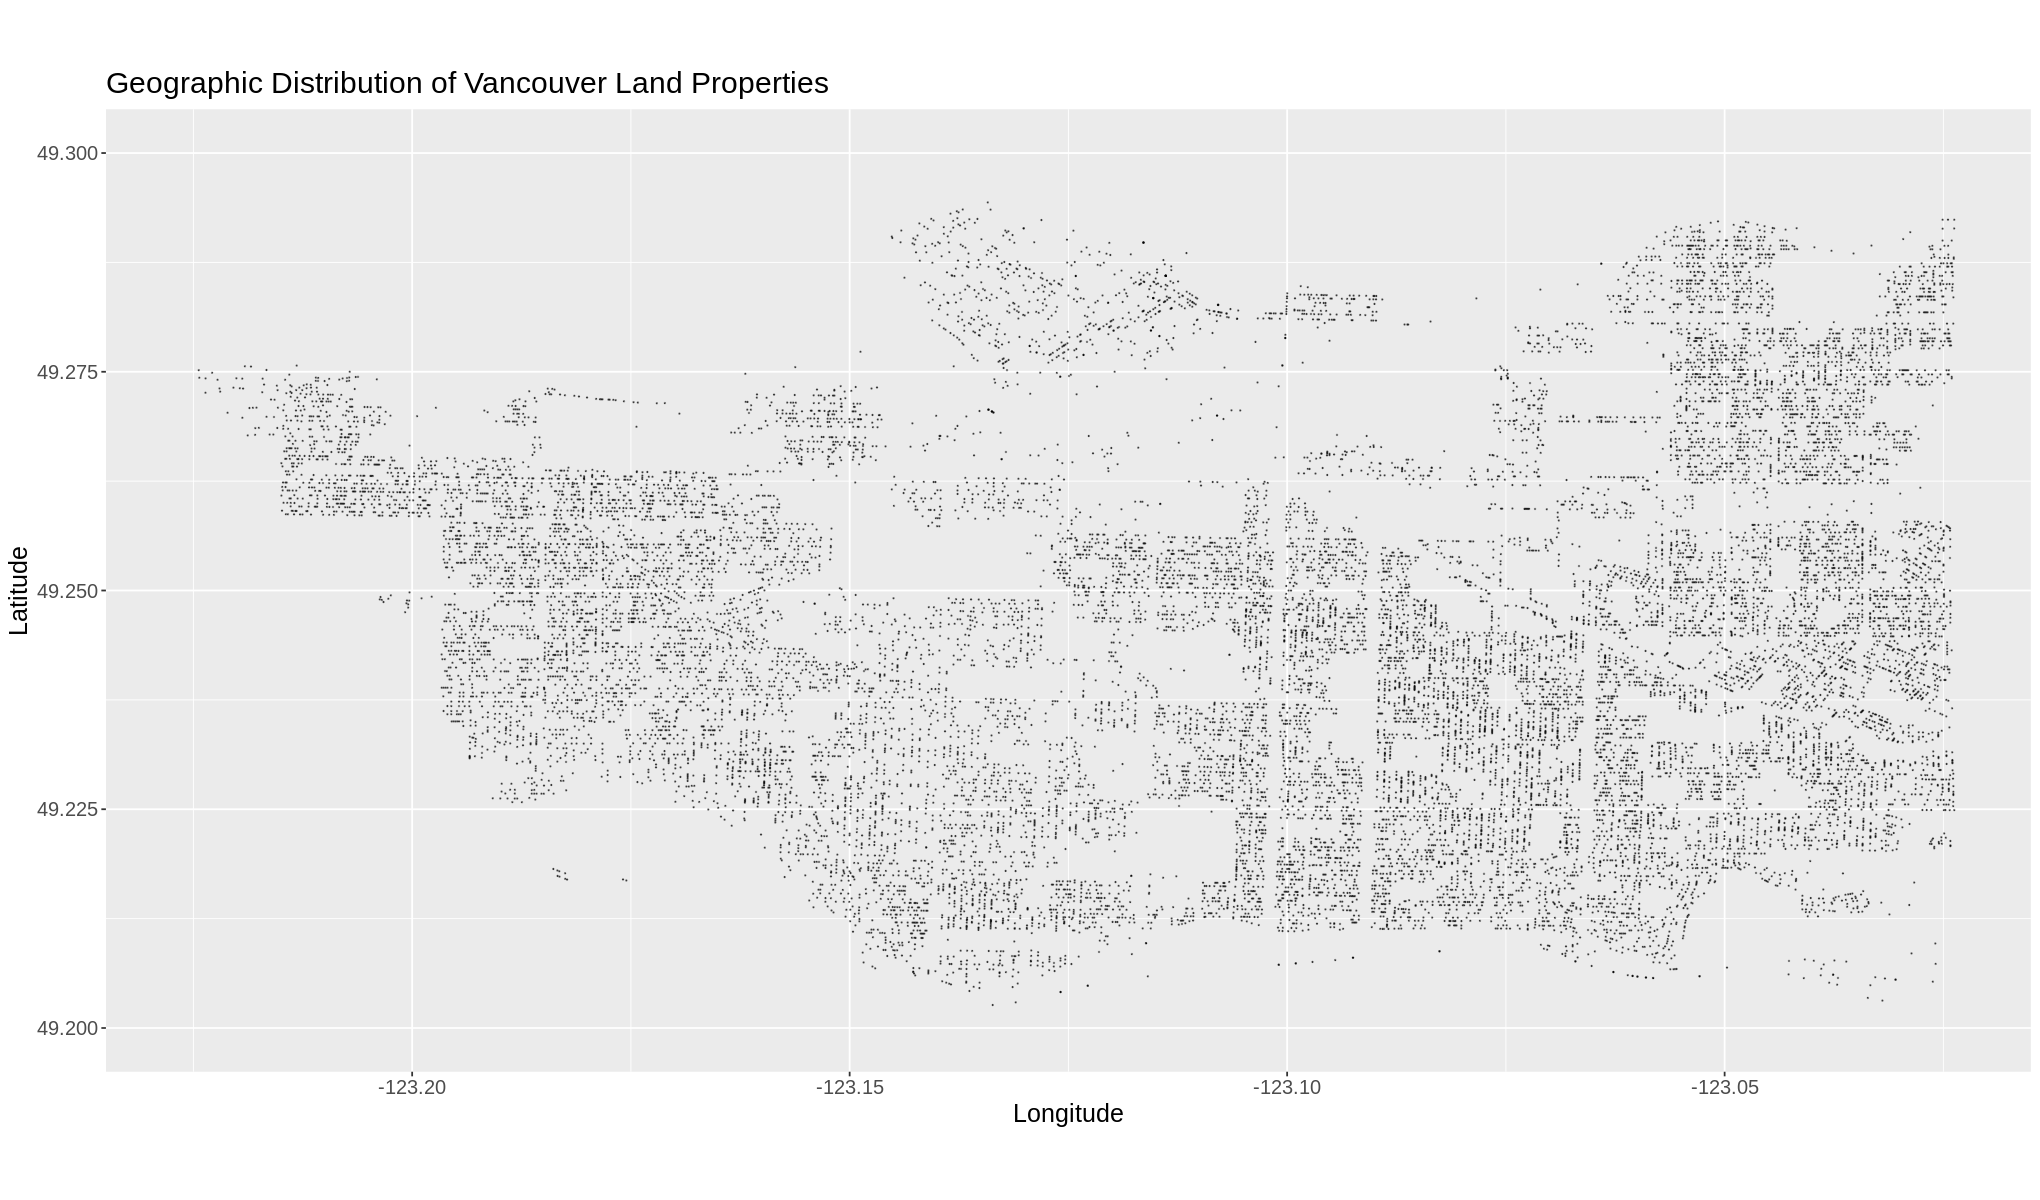

In [15]:
#This is to show that properties can be mapped onto a plot
options(repr.plot.width = 17, repr.plot.height =10)
property_plot <- property_train |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                filter(LEGAL_TYPE == "LAND") |>
                ggplot(aes(x=long,y=lat)) +
                geom_point(alpha = 0.5, size = 0.025) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Current Land Value", 
                     title = "Geographic Distribution of Vancouver Land Properties") +
                theme(text = element_text(size = 15))
property_plot

Warning message:
“Removed 272 rows containing missing values (geom_point).”


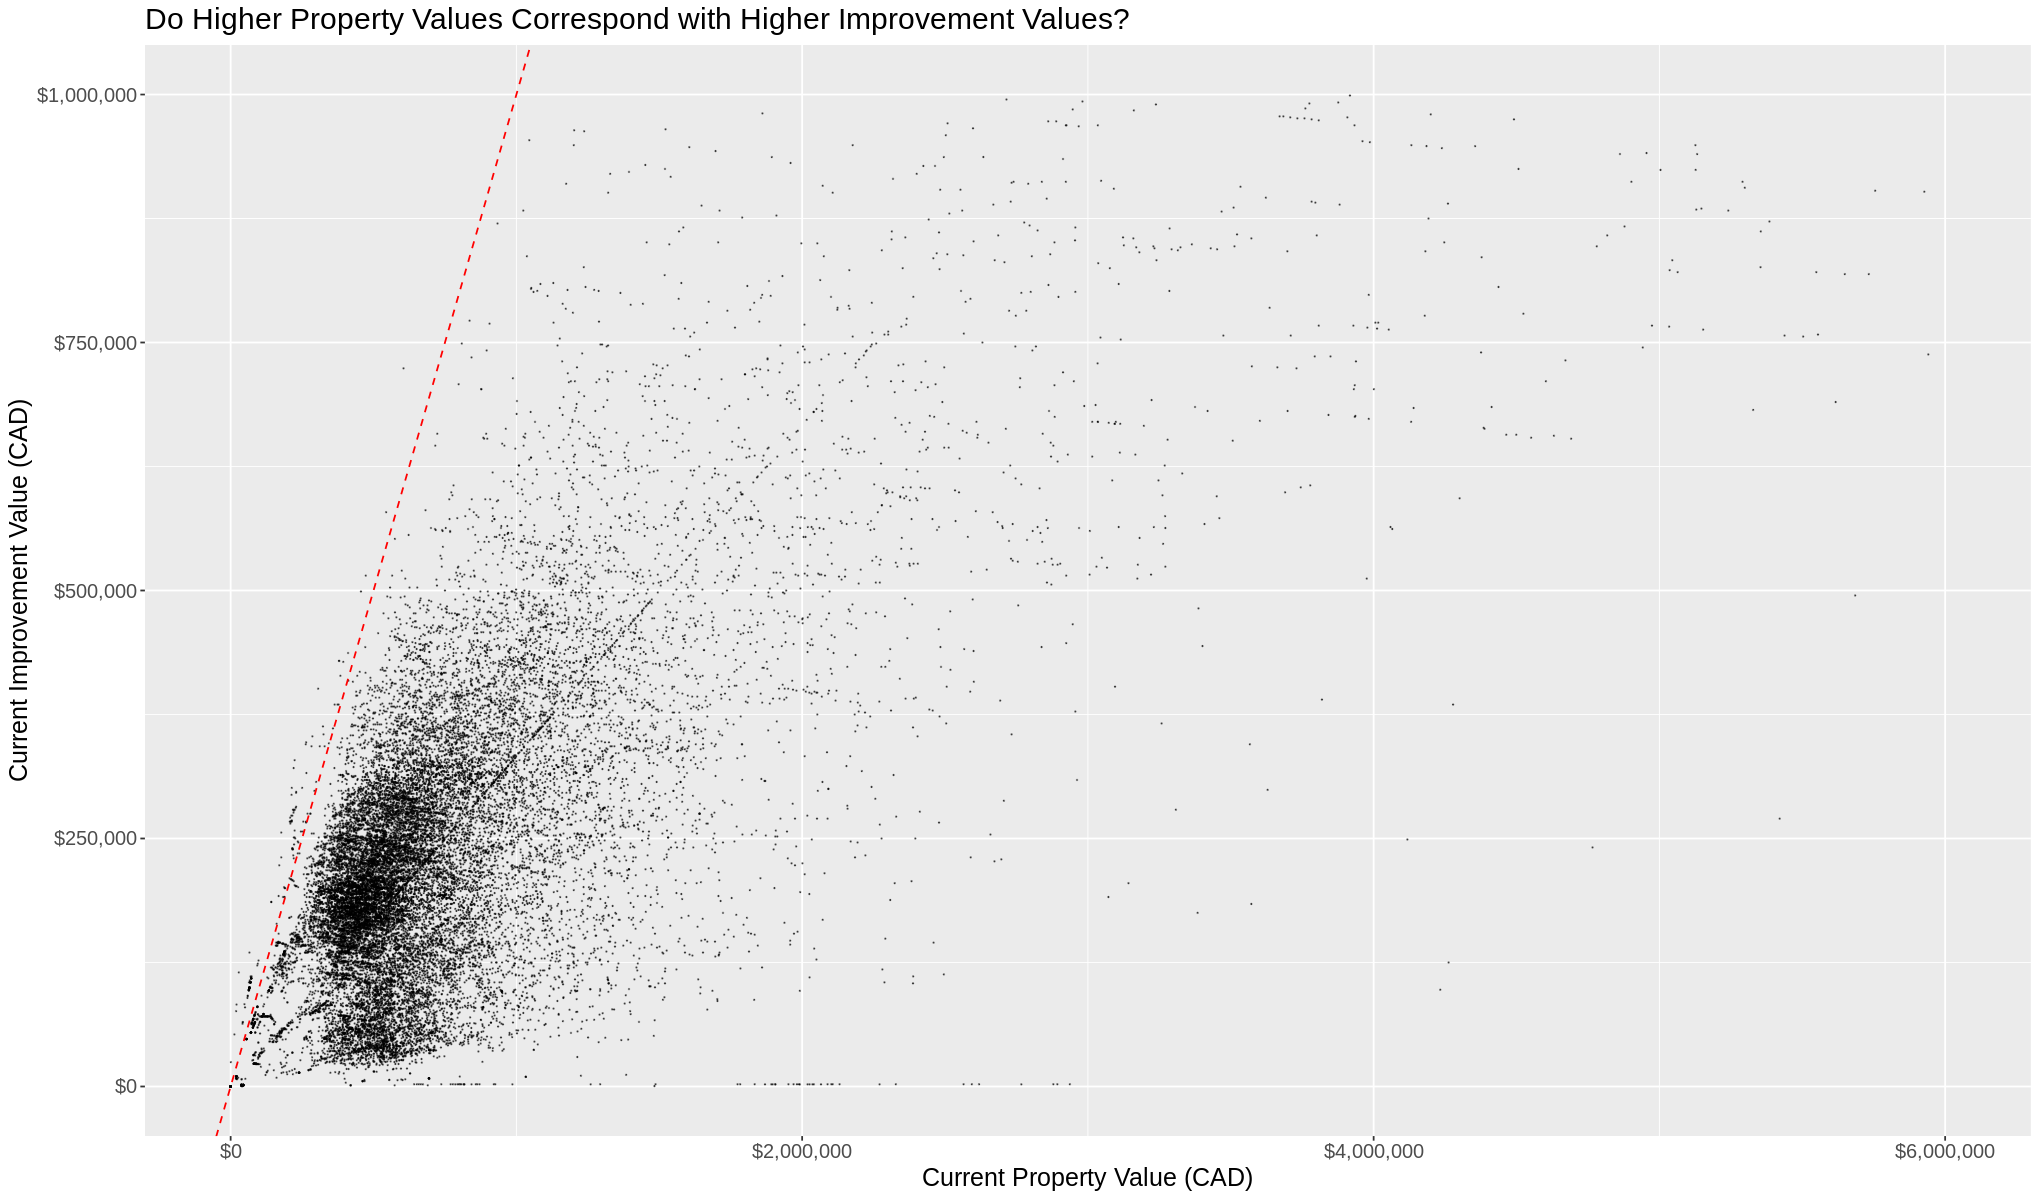

In [6]:
#scatterplot comparing property values with improvement value
#red dotted line shows what a 1:1 would look like, for reference
options(repr.plot.width = 17, repr.plot.height =10)
pval_vs_impv <- property_train |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=CURRENT_LAND_VALUE,y=CURRENT_IMPROVEMENT_VALUE)) +
                geom_point(alpha = 0.5, size = 0.025) +
                geom_abline(intercept = 0, slope = 1, color="red", linetype="dashed", size=0.5) +
                labs(x = "Current Property Value (CAD)", y = "Current Improvement Value (CAD)", 
                     title = "Do Higher Property Values Correspond with Higher Improvement Values?") +
                scale_x_continuous(labels=scales::dollar_format(), limits = c(0, 6*10^6)) +
                scale_y_continuous(labels=scales::dollar_format(), limits = c(0, 10^6)) +
                theme(text = element_text(size = 15))
pval_vs_impv

Warning message:
“Removed 642 rows containing missing values (geom_point).”


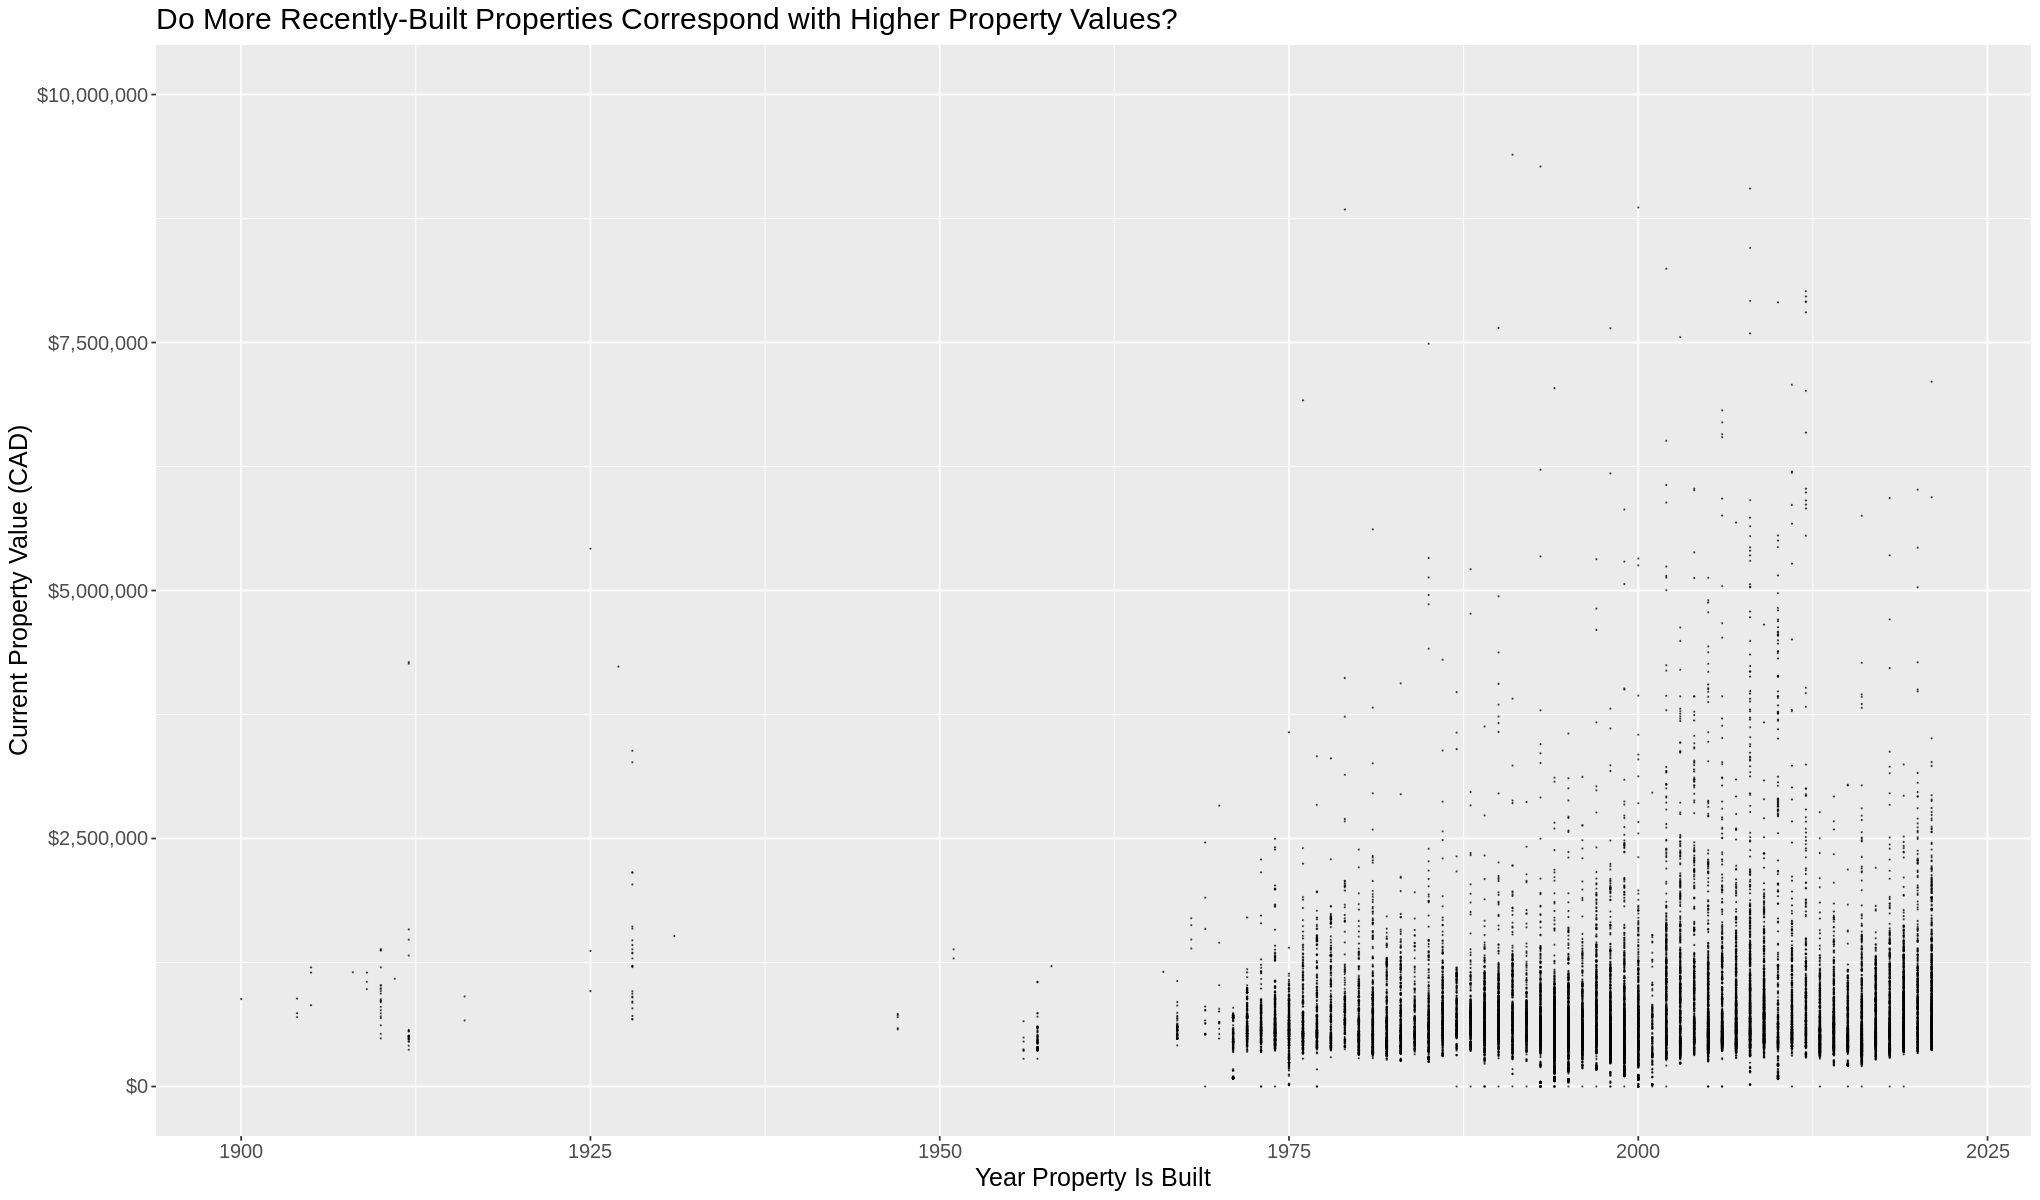

In [13]:
#scatterplot showing current property values against the years the properties were built
#red dotted line shows what a 1:1 would look like, for reference
options(repr.plot.width = 17, repr.plot.height =10)
pval_vs_year_built <- property_train |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=YEAR_BUILT,y=CURRENT_LAND_VALUE)) +
                geom_point(alpha = 0.5, size = 0.05) +
                labs(x = "Year Property Is Built", y = "Current Property Value (CAD)", 
                     title = "Do More Recently-Built Properties Correspond with Higher Property Values?") +
                xlim(1900,2022) +
                scale_y_continuous(labels=scales::dollar_format(), limits = c(0, 10^7)) +
                theme(text = element_text(size = 15))
pval_vs_year_built

Warning message:
“Removed 642 rows containing missing values (geom_point).”


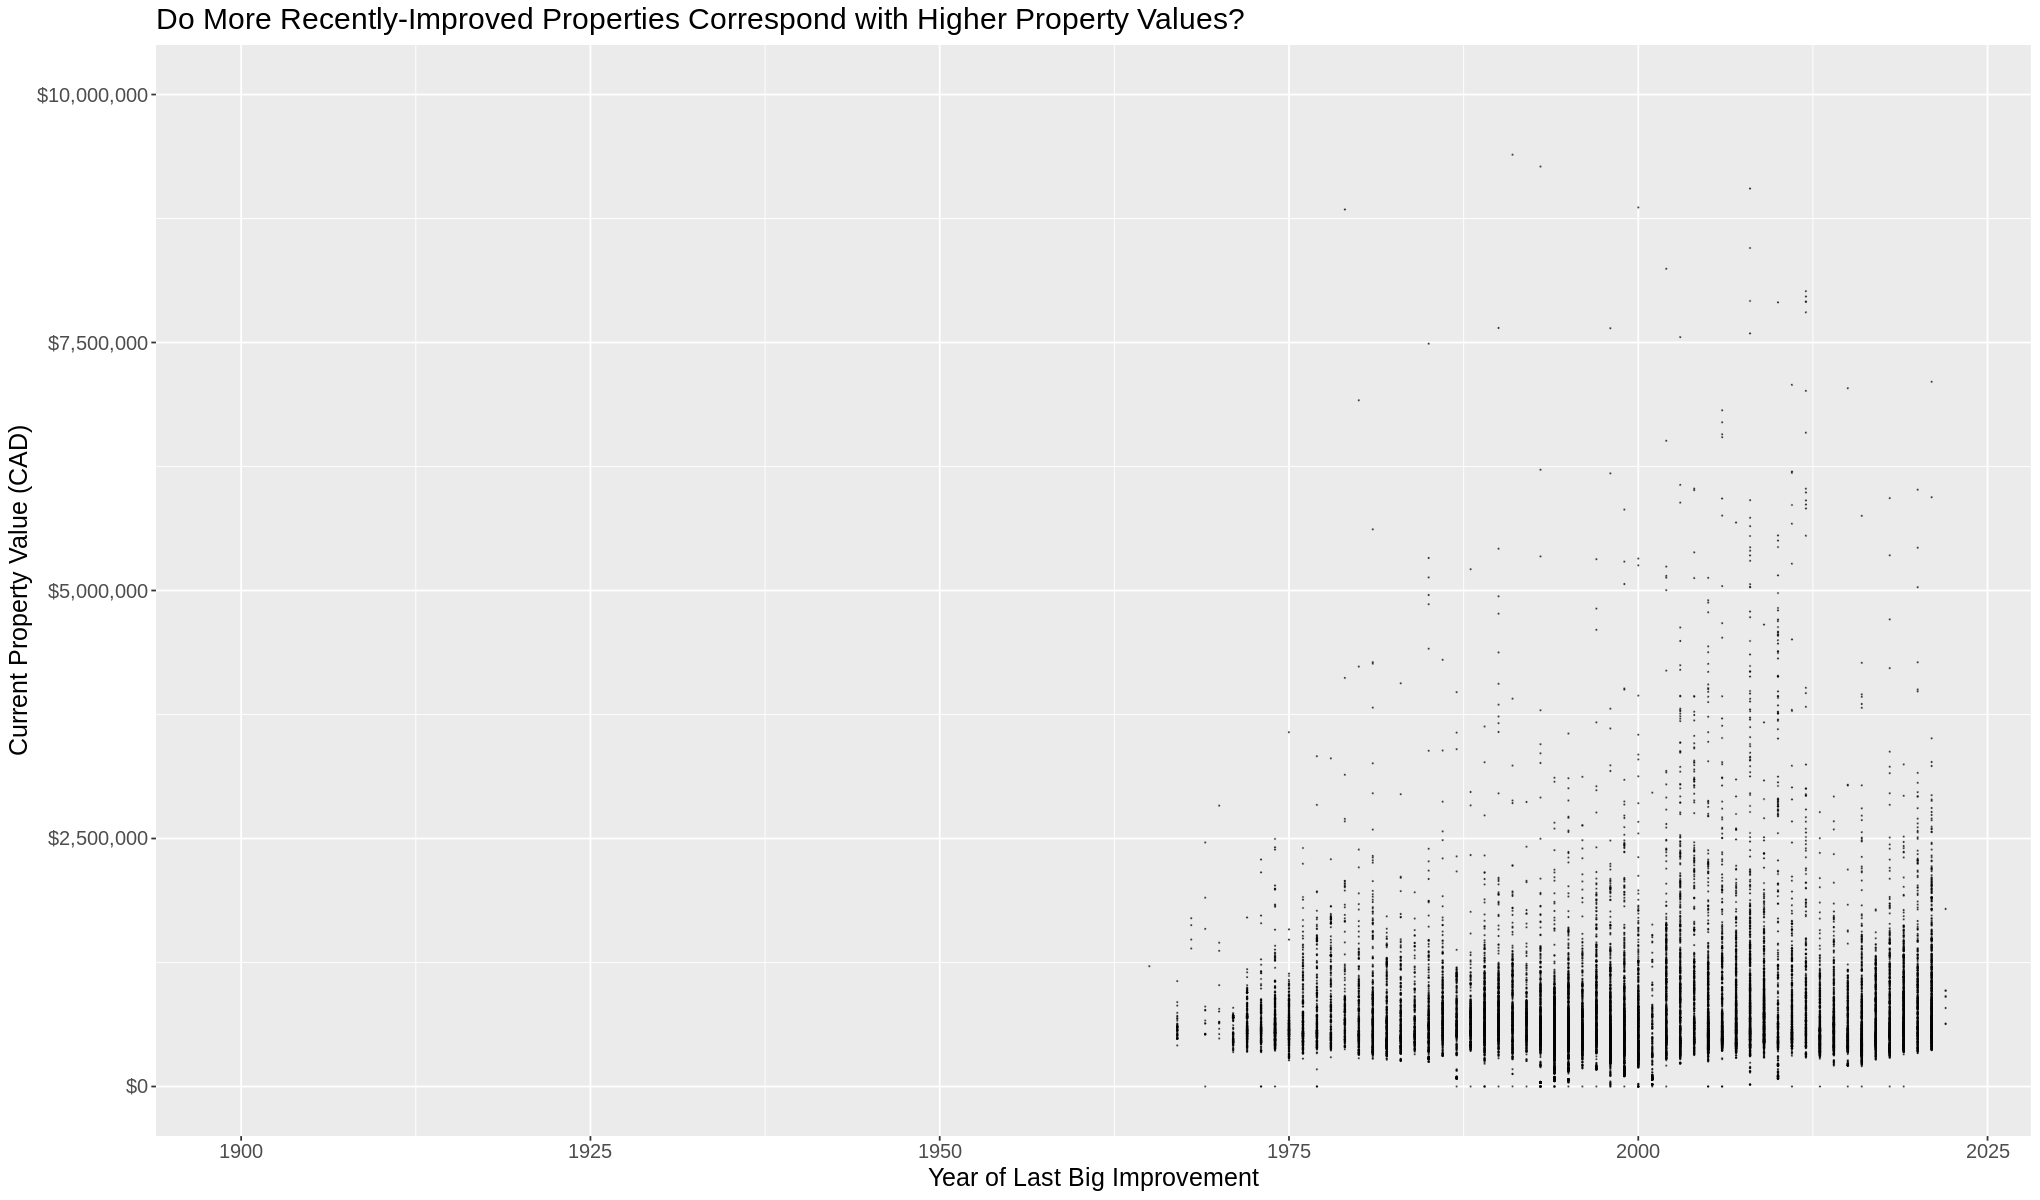

In [14]:
#scatterplot comparing big improvement year with improvement value
#red dotted line shows what a 1:1 would look like, for reference
options(repr.plot.width = 17, repr.plot.height =10)
pval_vs_year_impv <- property_train |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=BIG_IMPROVEMENT_YEAR,y=CURRENT_LAND_VALUE)) +
                geom_point(alpha = 0.5, size = 0.025) +
                labs(x = "Year of Last Big Improvement", y = "Current Property Value (CAD)", 
                     title = "Do More Recently-Improved Properties Correspond with Higher Property Values?") +
                xlim(1900,2022) +
                scale_y_continuous(labels=scales::dollar_format(), limits = c(0, 10^7)) +
                theme(text = element_text(size = 15))
pval_vs_year_impv

## Methods ##

We will use k-nearest neighbors regression for our data analysis, which will allow us to predict the cost of a new property (or a property to be resold) based on its age, location, and improvement value.

We will also map properties onto a map of Vancouver. We first do this by merging the “property tax report” dataset with the “Property parcel polygons” dataset via the LAND_COORDINATE column, which lets us match up the properties in the former with coordinate data in the latter. Then we plot it by latitude and longitude (contained in geo_point_2d column). We demonstrate an example of this above. We can then zone properties (or heat map them) based on qualities like property value.

Results of our analyses will also be visualized on scatterplots that compare various parameters, much like in the example above.

Columns we will use from the “Property tax report” dataset: 
LEGAL_TYPE,
LAND_COORDINATE, 
ZONING_CLASSIFICATION,
CURRENT_LAND_VALUE,
CURRENT_IMPROVEMENT_VALUE,
YEAR_BUILT,
BIG_IMPROVEMENT_YEAR,
TAX_LEVY

Column we will use from the “Property parcel polygons” dataset: LAND_COORDINATE, geo_point_2d

## What We Expect to Find ##

We expect to find higher property values to be clustered together, and likewise with lower property values. We suspect that neighbourhood has an effect on this. We also expect older properties to have lower property values, and that this effect is also moderated by neighbourhood (e.g. does neighbourhood be considered "rustic" or "vintage" as opposed to "old" and "run-down"?)

## Potential Impact of Our Findings ##

Our findings could help with cost-benefit analyses for prospective investors and proeprty developers to further provide affordable housing options while still earning profit. FUrthermore, our finding soculd be used to track trends in property value in future papers, in adjacent topics such as gentrification. 

## Future Questions ##

What other factors could contribute to Vancouver’s unaffordable property market?

**References**

(1) https://liv.rent/blog/rent-reports/october-2022-metro-vancouver-rent-report/#:~:text=rent%20are%20paying%2C%20on%20average,of%20their%20income%20towards%20rent.